In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_set_results = pd.read_csv('test_all_models.txt',skip_blank_lines=True,delim_whitespace=True,names=['random_seed','hidden','MAE','RMSE','R2','PEARSON'])

In [3]:
# simulation_setup RTX 3090; 64, 128, 256
simulation_speeds =         np.array([[28.5,16.9,9.17], # 128
                             [34.8,21.4,11.8],
                             [43,28.1,16.1],
                             [45.7,33.4,19.6]])

simulation_speeds[:,0] *= 64
simulation_speeds[:,1] *= 128
simulation_speeds[:,2] *= 256

exp_3090_ref = 937

In [4]:
test_set_results

,random_seed,hidden,MAE,RMSE,R2,PEARSON
0,1,48,5.311905,9.080699,0.993304,0.996650
1,1,64,5.065377,8.609815,0.993980,0.996995
2,1,96,4.784358,8.055551,0.994730,0.997389
3,1,128,4.585881,7.685227,0.995204,0.997616
4,2,48,5.338575,9.122822,0.993242,0.996628
5,2,64,5.091256,8.650021,0.993924,0.996973
6,2,96,4.763875,7.993013,0.994812,0.997413
7,2,128,4.579104,7.651880,0.995245,0.997630
8,3,48,5.350449,9.169399,0.993172,0.996602
9,3,64,5.080727,8.637758,0.993941,0.996977


In [5]:
def initialize_plt():
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['figure.dpi'] = 100
initialize_plt()

# Plot predicted vs actual external test

In [6]:
#reload automatically
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import os
sys.path.append('../')
sys.path.append('../MachineLearning/')
import pandas as pd
from GNN_Trainer import Trainer
from GNN_Models import *
from GNN_Loss_Functions import *
import torch
from analysis import initialize_plt
import matplotlib.pyplot as plt

In [8]:
pt_file = '../MachineLearning/datasets/test_set.pt' # Needs to be downloaded from ETH Research Collection
gnn_file = '../MachineLearning/trained_models/GNN.model'

In [9]:
trainer = Trainer(verbose=False,name='GNN3_pub_vis',path='trained_models',force_mode=True,enable_tmp_dir=False,random_state=3)

device = 'cuda'
trainer.explicit = True
print('load data',flush=True)
trainer.prepare_training_data_from_pt_file(pt_file)
print('data loaded',flush=True)
trainer.model = torch.load(gnn_file,map_location=device)
trainer.set_lossfunction(calculate_force_loss_only)
loss = trainer.test_model()
pre,exp = trainer.return_test_set_predictions()

load data


data loaded


RMSE: 8.650


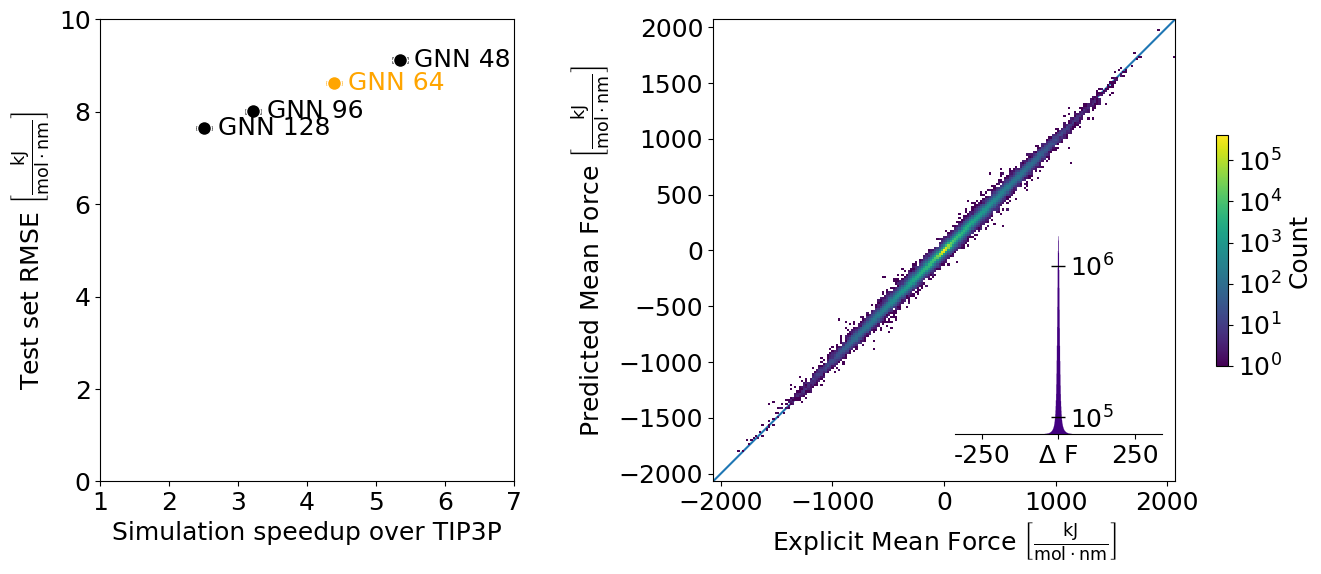

In [12]:
df = pd.DataFrame()
df['RMSE'] = test_set_results.groupby('hidden').mean().RMSE
df['std'] = test_set_results.groupby('hidden').std().RMSE

marker_style = dict(fmt='o', markersize=10, capsize=6, capthick=2, markeredgecolor='white')
fig,axd = plt.subplot_mosaic([['speed','comp']],figsize=(16,6),width_ratios=[1,2])
fig.subplots_adjust(wspace=0)

Trainer.plot_forces_comparison(pre,exp,hist_bins=200,iax=axd['comp'])
for g in range(4):
    color = 'orange' if (g == 1) else 'black'
    axd['speed'].errorbar(simulation_speeds[:,2][::-1][g]/exp_3090_ref,df.RMSE.values[g],yerr=df['std'].values[g],c=color,**marker_style)
labels = ['GNN 48', 'GNN 64', 'GNN 96', 'GNN 128']  # replace with your labels
ax = axd['speed']
for i, label in enumerate(labels):
    color = 'orange' if (i == 1) else 'black'
    ax.annotate(label, (simulation_speeds[:,2][::-1][i]/exp_3090_ref + 0.2, df.RMSE.values[i] - 0.15),color=color)

ax.set_xlim(1,7)
ax.set_ylim(0,10)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xlabel('Simulation speedup over TIP3P')
_ = ax.set_ylabel(r'Test set RMSE $\left [\mathrm{\frac{kJ}{mol \cdot nm}} \right ]$')